Implementing GPU gems incompressible fluid solver

https://developer.download.nvidia.com/books/HTML/gpugems/gpugems_ch38.html

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [214]:
# Need to allow GPU memory growth for TF so all 8 GB or whatever are not taken up
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Create fluid grid (will start with hard-coded 512x512 2D grid)
# Incompressible fluid: fluid state boils down to a velocity field (3 variables)
N = 16 # Number of cells on each side of simulation grid
u = np.zeros((N, N, 2)) # An NxN grid of fluid velocity 2-vectors

# Initialize grid
for i in range(N):
    for j in range(N):
        if ((i-(N/2.))**2 + (j-(N/2.))**2) < (N/4.)**2:
            u[i, j] = np.array([-1., 1.])

# Collect nobel prize

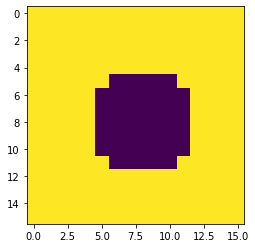

In [215]:
plt.figure()
plt.imshow(u[:, :, 0])

For periodic boundary conditions, it may be a good idea to copy one side of the grid to the other instead of using 'if's to check bounds.

Solving $\left(I - \nu \delta \nabla^2\right) u \left(x, t + \delta t \right) = u\left(x, t \right)$

In [232]:
def interpolate(i, u, q, dt):
    xcoords = tf.cast(tf.cast(i % N, tf.int32) - dt * u[tf.cast(i % N, tf.int32), tf.cast(i // N, tf.int32)][0], tf.float32)
    ycoords = tf.cast(tf.cast(i // N, tf.int32) - dt * u[tf.cast(i % N, tf.int32), tf.cast(i // N, tf.int32)][1], tf.float32)
    return (q[tf.cast(tf.floor(xcoords), tf.int32), tf.cast(tf.floor(ycoords), tf.int32)] * (tf.math.ceil(xcoords) - xcoords) * (tf.math.ceil(ycoords) - ycoords) +
            q[tf.cast(tf.math.ceil(xcoords), tf.int32), tf.cast(tf.floor(ycoords), tf.int32)] * (tf.floor(xcoords) - xcoords) * (tf.math.ceil(ycoords) - ycoords) +
            q[tf.cast(tf.floor(xcoords), tf.int32), tf.cast(tf.math.ceil(ycoords), tf.int32)] * (tf.math.ceil(xcoords) - xcoords) * (tf.floor(ycoords) - ycoords) +
            q[tf.cast(tf.math.ceil(xcoords), tf.int32), tf.cast(tf.math.ceil(ycoords), tf.int32)] * (tf.floor(xcoords) - xcoords) * (tf.floor(ycoords) - ycoords))
    
# u: velocity (shape = N, N, 2)
# q: quantity to advect
# dt: timestep
# (x, y) convection for loops. x = i % N, y = i // N
def advect(u, q, dt):
    data = tf.zeros([N ** 2, 2])
    
    ini = [tf.constant(0, dtype=tf.int32), tf.constant([1, 2])]
    test = partial(interpolate, u=u, q=q, dt=dt)
    cond = lambda k, p: k < N * N
    func = lambda k, p: (k + 1, test(k))
    count, data = tf.while_loop(cond, func, loop_vars=ini, parallel_iterations=2560)
    
    return data

In [233]:
data = advect(u, u, 0.1)

In [234]:
data

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [ ]:
def diffuse(u):
    return u

In [ ]:
def addForces(u):
    return u

In [ ]:
def computePressure(u):
    return p

In [ ]:
def subtractPressureGradient(u, p):
    return u

In [ ]:
u = advect(u)
u = diffuse(u)
u = addForces(u)
p = computePressure(u)
u = subtractPressureGradient(u, p)

In [6]:
tf.compat.v1.enable_eager_execution()